# Обучение модели

## Импорт библиотек

In [ ]:
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm, trange
import cv2
import numpy as np
import seaborn as sns

Подключаем Google Drive, чтобы иметь доступ к фотографиям для обучения модели.

Подключаем самописные модули.

In [ ]:
from dataset import *
from model import predict
from metrics_and_loss_fn import iou_pytorch
import objects
from utils import (
                seed_everything,
                make_logical_masks_and_bboxes,
                draw_seg_masks,  draw_bboxes
                  )

## UNet с предобученными весами (Pretrained Backbones with UNet)
Это основанная на PyTorch библиотека Python с архитектурой UNet и множеством базовых компонентов (веса, архитектура модели и др.) для семантической сегментации изображений. Подгрузим эту библиотеку.

In [ ]:
!pip install pretrained-backbones-unet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 12.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

Импортируем нужные модули. Попробуем обучить так.

In [ ]:
from backbones_unet.model.unet import Unet
from backbones_unet.utils.dataset import SemanticSegmentationDataset
from backbones_unet.model.losses import DiceLoss

Получаем список фотографий для обучения модели. Помним, что у нас названия файлов для карт растительности и для фотографий фрагментов поля совпадают.

In [ ]:
TRAIN_MASK_DIR = "/content/drive/MyDrive/plants_detection/dataset/mask"
TRAIN_IMG_DIR  = "/content/drive/MyDrive/plants_detection/dataset/img"

paths_all = os.listdir(TRAIN_IMG_DIR)

Из-за ограничений Google Colab  сократим обучающую выборку. В дальнейшем планируется сделать 42 раза обучение модели на разных выборках.

In [ ]:
SEED = 42
batch_size = 2
seed_everything(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Разбиваем данные и подготавливаем их для обучения модели.

In [ ]:
def make_dataloaders(paths):
  data_train, data_test = train_test_split(
                                  list(zip(paths, paths)),
                                  test_size=0.2,
                                  random_state=SEED
                                  )

  data_val, data_test = train_test_split(data_test, test_size=0.5,
                                    random_state=SEED
                                    )

  train = PlantsDataset(data_train, TRAIN_IMG_DIR, TRAIN_MASK_DIR,
                        preprocessing =  train_img_preprocessing)
  val   = PlantsDataset(data_val, TRAIN_IMG_DIR, TRAIN_MASK_DIR)
  test  = PlantsDataset(data_test, TRAIN_IMG_DIR, TRAIN_MASK_DIR)

  print("Train:", len(train))
  print("Val:", len(val))
  print("Test:", len(test))

  train_loader = DataLoader(train, batch_size=batch_size,
                    shuffle=True, drop_last=True)
  val_loader = DataLoader(val, batch_size=batch_size,
                  shuffle=False, drop_last=True)
  test_loader = DataLoader(test,
                    batch_size=batch_size,
                  shuffle=False, drop_last=True)
  return train_loader, val_loader, test_loader

In [ ]:
model = Unet(
    backbone='convnext_base', # backbone network name
    in_channels=3,            # input channels (1 for gray-scale images, 3 for RGB, etc.)
    num_classes=1,            # output channels (number of classes in your dataset)
)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_1k_224_ema.pth


Training the contracting part and freezing the expanding part led to better
results compared to freezing the contracting part and fine-tuning the expanding
part

https://arxiv.org/pdf/2002.08438v1

Файнтюним только encoder, как сказано в статье.

### Trainer (первоначальный)

In [ ]:
from trainer import Trainer

In [ ]:
model.load_state_dict(torch.load('/content/model_v0.1.pth'))
model.to(device)
params = [p for p in model.encoder.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, 1e-4)

In [ ]:
paths = paths_all[:200]

In [ ]:
train_loader, val_loader, test_loader = make_dataloaders(paths)

Train: 160
Val: 20
Test: 20


In [ ]:
params = {
    'net': model,
    'epoch_amount': 50,
    'learning_rate': 1e-4,
    'loss_f': DiceLoss(),
    'optim': optimizer,
    'metric': iou_pytorch,
    'device': device,
}

clf = Trainer(**params)

In [ ]:
clf.fit(model, train_loader, val_loader)

* Epoch 1/50
Loss_train: 0.8257400460541249, 0:00:13.615603 сек
Loss_val: 0.8216142296791077, 0:00:14.260367 сек

* Epoch 2/50
Loss_train: 0.8244575582444668, 0:00:14.173314 сек
Loss_val: 0.8209997415542603, 0:00:14.810332 сек

* Epoch 3/50
Loss_train: 0.824734365940094, 0:00:13.687593 сек
Loss_val: 0.820811927318573, 0:00:14.297540 сек

* Epoch 4/50
Loss_train: 0.8243153139948844, 0:00:13.537473 сек
Loss_val: 0.8206242918968201, 0:00:14.143864 сек

* Epoch 5/50
Loss_train: 0.8235268250107766, 0:00:13.464674 сек
Loss_val: 0.8204458355903625, 0:00:14.062756 сек

* Epoch 6/50
Loss_train: 0.8235387362539768, 0:00:13.624418 сек
Loss_val: 0.8201678335666657, 0:00:14.228965 сек

* Epoch 7/50
Loss_train: 0.8225664094090461, 0:00:13.525671 сек
Loss_val: 0.8197377920150757, 0:00:14.130604 сек

* Epoch 8/50
Loss_train: 0.8225153364241123, 0:00:13.564345 сек
Loss_val: 0.8197154998779297, 0:00:14.177485 сек

* Epoch 9/50
Loss_train: 0.8222923822700977, 0:00:13.582167 сек
Loss_val: 0.81988003253936

Модель обучается очень медленно. Попробуем другой trainer, продолжим обучение. Подготовим данные.

### Trainer (from backbones)

In [ ]:
paths = paths_all[200:400]

In [ ]:
train_loader, val_loader, test_loader = make_dataloaders(paths)

Train: 160
Val: 20
Test: 20


In [ ]:
from backbones_unet.utils.trainer import Trainer

In [ ]:
trainer = Trainer(
    model,                    # UNet model with pretrained backbone
    criterion=DiceLoss(),     # loss function for model convergence
    optimizer=optimizer,      # optimizer for regularization
    epochs=10                # number of epochs for model training
)

In [ ]:
trainer.fit(train_loader, val_loader)

Epoch 1: 100%|██████████| 80/80 [00:18<00:00,  4.40 training-batch/s, loss=0.688]

Epoch 2: 100%|██████████| 80/80 [00:18<00:00,  4.38 training-batch/s, loss=0.697]

Epoch 3: 100%|██████████| 80/80 [00:18<00:00,  4.40 training-batch/s, loss=0.722]

Epoch 4: 100%|██████████| 80/80 [00:18<00:00,  4.40 training-batch/s, loss=0.701]

Epoch 5: 100%|██████████| 80/80 [00:18<00:00,  4.29 training-batch/s, loss=0.687]

Epoch 6: 100%|██████████| 80/80 [00:18<00:00,  4.37 training-batch/s, loss=0.719]

Epoch 7: 100%|██████████| 80/80 [00:18<00:00,  4.39 training-batch/s, loss=0.701]

Epoch 8: 100%|██████████| 80/80 [00:18<00:00,  4.26 training-batch/s, loss=0.668]

Epoch 9: 100%|██████████| 80/80 [00:18<00:00,  4.25 training-batch/s, loss=0.676]

Epoch 10: 100%|██████████| 80/80 [00:18<00:00,  4.27 training-batch/s, loss=0.724]

Traning Model on 10 epochs: 100%|██████████| 10/10 [03:12<00:00, 19.24s/it]


In [ ]:
trainer.model.decoder.parameters

UnetDecoder(
  (center): Identity()
  (blocks): ModuleList(
    (0): DecoderBlock(
      (conv1): Conv2dBnAct(
        (conv): Conv2d(1536, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (conv2): Conv2dBnAct(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
    )
    (1): DecoderBlock(
      (conv1): Conv2dBnAct(
        (conv): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (conv2): Conv2dBnAct(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=

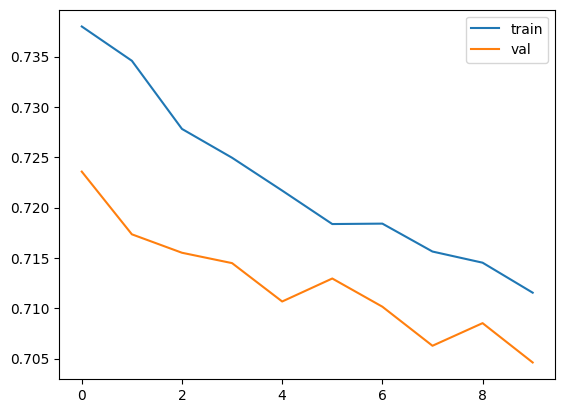

In [ ]:
plt.plot(range(len(trainer.train_losses_)), trainer.train_losses_, label='train')
plt.plot(range(len(trainer.val_losses_)), trainer.val_losses_, label='val')
plt.legend()

In [ ]:
PATH = '/content/model_v0.1.pth'

In [ ]:
torch.save(trainer.model.state_dict(), PATH)

Обучение идет нормально, но могло быть и лучше. Расширим функционал исходного trainer'а, чтобы можно было оценивать качество предсказания по метрике IoU, сохранять модель во время обучения сразу в папку с моделями.

## Extended Trainer -> Custom Trainer

In [ ]:
from backbones_unet.utils.trainer import Trainer

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = model(X_batch)
        Y_pred = (Y_pred > 0).type(torch.uint8)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

In [ ]:
class CustomTrainer(Trainer):
  def __init__(
        self,
        model,
        criterion,
        optimizer,
        epochs,
        path_to_model,
        scaler=None,
        lr_scheduler=None,
        device=None
     ):
    super().__init__(
        model,
        criterion,
        optimizer,
        epochs,
        scaler,
        lr_scheduler,
        device
        )
    self.path_to_model = path_to_model
    self.best_vloss = float('inf')
    self.best_score = 0

  def fit(self, train_loader, val_loader):
        """
        Fit the model using the given loaders for the given number
        of epochs.

        Parameters
        ----------
        train_loader :
        val_loader :
        """
        # attributes
        self.train_losses_ = torch.zeros(self.epochs)
        self.val_losses_ = torch.zeros(self.epochs)
        # ---- train process ----
        for epoch in trange(1, self.epochs + 1,
                            desc='Traning Model on {} epochs'.format(self.epochs)):
            # train
            self._train_one_epoch(train_loader, epoch)
            # validate
            self._evaluate(val_loader, epoch)

            cur_score = score_model(self.model, iou_pytorch, val_loader)
            path_ending = f"_{self.val_losses_[epoch - 1]:.4f}_vloss{cur_score:.4f}_score.pth"

            print("Current model score:", cur_score)
            print("Best model score:", self.best_score)

            if self.val_losses_[epoch - 1] < self.best_vloss:
              self.best_vloss = self.val_losses_[epoch - 1]
              torch.save(self.model.state_dict(),
                         self.path_to_model + path_ending)

            if cur_score > self.best_score:
               self.best_score = cur_score
               torch.save(self.model.state_dict(),
                          self.path_to_model + path_ending)




In [ ]:
paths = paths_all[600:800]

In [ ]:
train_loader, val_loader, test_loader = make_dataloaders(paths)

Train: 160
Val: 20
Test: 20


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/plants_detection/models/model_v0.2_vloss.pth'))
model.to(device)
params = [p for p in model.decoder.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, 1e-4)

In [ ]:
trainer = CustomTrainer(
    model,                    # UNet model with pretrained backbone
    criterion=DiceLoss(),     # loss function for model convergence
    optimizer=optimizer,      # optimizer for regularization
    epochs=10,                # number of epochs for model training
    path_to_model='/content/drive/MyDrive/plants_detection/models/model_v0.3',
    device=device
)

In [ ]:
sum(torch.tensor(params[0].size()).sum().tolist() for param in params)


57536

In [ ]:
trainer.fit(train_loader, val_loader)

Epoch 1: 100%|██████████| 80/80 [05:36<00:00,  4.20s/ training-batch, loss=0.702]

Validation: 100%|██████████| 10/10 [00:35<00:00,  3.57s/ validating-batch, loss=0.65]


Current model score: 0.0
Best model score: 0


Epoch 2: 100%|██████████| 80/80 [00:16<00:00,  4.93 training-batch/s, loss=0.718]

Validation: 100%|██████████| 10/10 [00:00<00:00, 12.05 validating-batch/s, loss=0.653]


Current model score: 0.0
Best model score: 0


Epoch 3: 100%|██████████| 80/80 [00:16<00:00,  4.78 training-batch/s, loss=0.773]

Validation: 100%|██████████| 10/10 [00:00<00:00, 10.25 validating-batch/s, loss=0.64]


Current model score: 0.0
Best model score: 0


Epoch 4: 100%|██████████| 80/80 [00:17<00:00,  4.66 training-batch/s, loss=0.68]

Validation: 100%|██████████| 10/10 [00:00<00:00, 11.09 validating-batch/s, loss=0.614]


Current model score: 0.0
Best model score: 0


Epoch 5: 100%|██████████| 80/80 [00:17<00:00,  4.65 training-batch/s, loss=0.701]

Validation: 100%|██████████| 10/10 [00:00<00:00, 12.91 validating-batch/s, loss=0.574]


Current model score: 0.0
Best model score: 0


Epoch 6: 100%|██████████| 80/80 [00:17<00:00,  4.45 training-batch/s, loss=0.665]

Traning Model on 10 epochs:  60%|██████    | 6/10 [07:54<02:41, 40.37s/it]

Current model score: 0.0
Best model score: 0



Epoch 7: 100%|██████████| 80/80 [00:16<00:00,  4.77 training-batch/s, loss=0.608]

Validation: 100%|██████████| 10/10 [00:00<00:00, 10.11 validating-batch/s, loss=0.559]


Current model score: 0.0
Best model score: 0


Epoch 8: 100%|██████████| 80/80 [00:17<00:00,  4.60 training-batch/s, loss=0.548]

Traning Model on 10 epochs:  80%|████████  | 8/10 [08:33<00:57, 28.97s/it]

Current model score: 0.0
Best model score: 0



Epoch 9: 100%|██████████| 80/80 [00:16<00:00,  4.71 training-batch/s, loss=0.517]

Validation: 100%|██████████| 10/10 [00:00<00:00, 12.38 validating-batch/s, loss=0.53]


Current model score: 0.0
Best model score: 0


Epoch 10: 100%|██████████| 80/80 [00:17<00:00,  4.48 training-batch/s, loss=0.549]

Validation: 100%|██████████| 10/10 [00:01<00:00,  9.69 validating-batch/s, loss=0.523]


Current model score: 0.0
Best model score: 0


Traning Model on 10 epochs: 100%|██████████| 10/10 [09:15<00:00, 55.52s/it]


Посмотрим, что предсказывает наша модель.

In [ ]:
def predict(model, data):
  global device
  model.eval()  # testing mode
  with torch.no_grad():
    data = data.to(device)
    pred = model(data)
    pred = (pred > 0).type(torch.uint8)
    return pred

In [ ]:
# создадим маску и bounding box-ы для тестового изображения
dataset_tests = PlantsDataset([(paths[-1], paths[-1])], TRAIN_IMG_DIR, TRAIN_MASK_DIR)

In [ ]:
pred_mask = predict(trainer.model, dataset_tests[0][0].unsqueeze(0))

In [ ]:
res = pred_mask.squeeze(0, 1).cpu().numpy()

In [ ]:
res.shape

(256, 256)

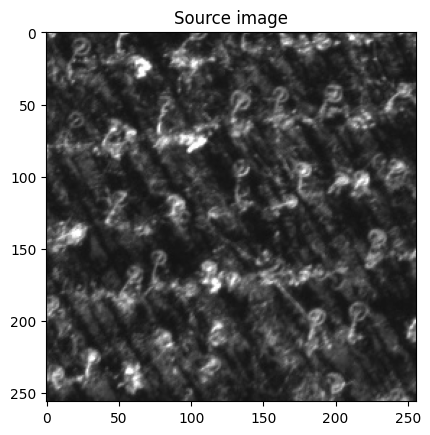

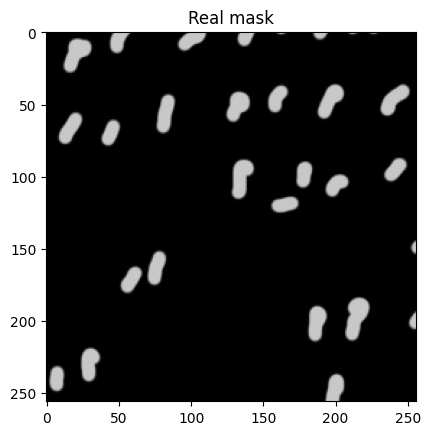

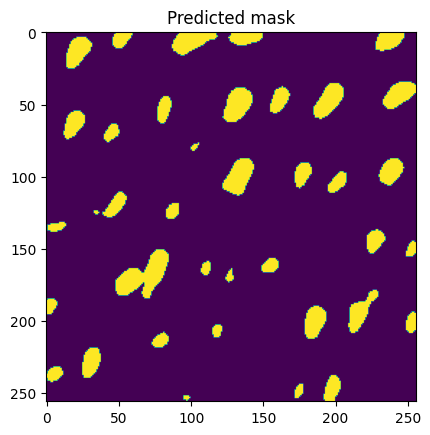

In [ ]:


plt.imshow(load_image(os.path.join(TRAIN_IMG_DIR, paths[-1])))
plt.title('Source image')
plt.show()

plt.imshow(load_image(os.path.join(TRAIN_MASK_DIR, paths[-1])))
plt.title('Real mask')
plt.show()

plt.imshow(res)
plt.title('Predicted mask')
plt.show()

In [ ]:
def polygon_area_by_points(points):
  area = 0
  last = len(points) - 1
  for i in range(len(points)):
      area += points[last][0] * points[i][1] - points[last][1] * points[i][0]
      last = i
  return 0.5 * abs(area)

In [ ]:
contours, _ = cv2.findContours(res, cv2.RETR_EXTERNAL,
                                           cv2.CHAIN_APPROX_NONE)

In [ ]:
contours.__len__()

38

In [ ]:
contours[1].shape

(22, 1, 2)

In [ ]:
areas = []

In [ ]:
for i, contour in enumerate(contours):
   area = polygon_area_by_points(contour.squeeze())
   areas += [[i, area]]

In [ ]:
areas_sorted = sorted(areas, key=lambda x: x[1])

In [ ]:
x, y = zip(*areas_sorted)

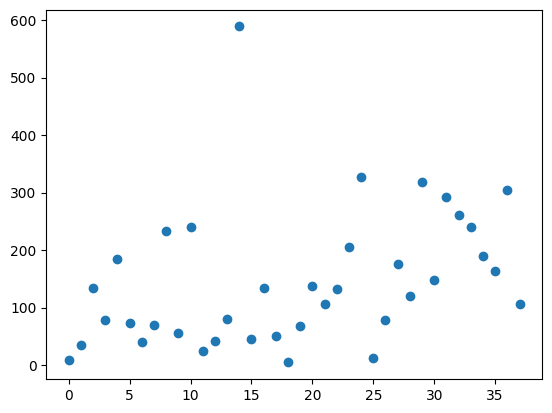

In [ ]:
plt.scatter(x, y)

<ipython-input-104-0f415a98584e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y)


<Axes: ylabel='Density'>

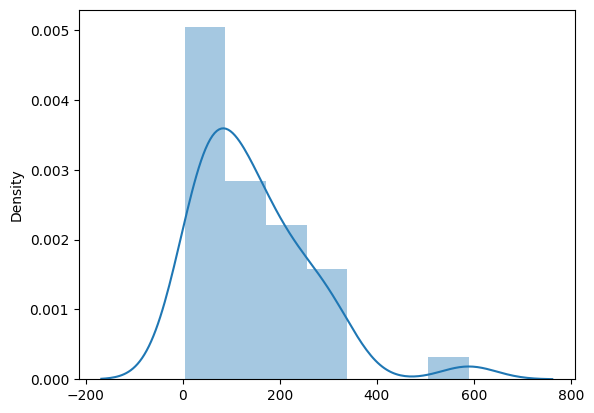

In [ ]:
sns.distplot(y)

Будем убирать предсказанные "подсолнухи", которые не касаются края картинки, но при этом похожи на выбросы. В следующем ноутбуке дообучим модель.